# Regresión Ponderada Geografica GWR

In [1]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tabulate import tabulate

np.float = float

In [2]:
gdf = gpd.read_file("https://github.com/algarciach/AnalisisGeoespacial/raw/main/Covid19_model/Data/covid19_municipios_antioquia.gpkg")
gdf.info()

In [64]:
gdf['y_log'] = np.log(gdf['cfr'] + 1)
g_y = gdf['y_log'].values.reshape(-1, 1)

In [65]:
# Define coordinates as points
u = gdf.centroid.x
v = gdf.centroid.y
g_coords = list(zip(u, v))



/tmp/ipykernel_45849/1898457282.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  u = gdf.centroid.x
/tmp/ipykernel_45849/1898457282.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  v = gdf.centroid.y


In [66]:

variables = ["altitud", "humedad_relativa", "urbanizacion", "densidad"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(gdf[variables])
g_X_num = np.column_stack((np.ones(125), X_scaled)) 

In [94]:

model = GWR(g_coords_utm, g_y, g_X_num, bw=12500, fixed=True, kernel='gaussian').fit()
print(f"UTM BW=12,500 m, R²: {model.R2}, AIC: {model.aic}")
model.summary()

UTM BW=12,500 m, R²: 0.8411758131145283, AIC: 36.97855141065651
Model type                                                         Gaussian
Number of observations:                                                 125
Number of covariates:                                                     5

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                             12.573
Log-likelihood:                                                     -33.819
AIC:                                                                 77.639
AICc:                                                                80.351
BIC:                                                               -566.825
R2:                                                                   0.195
Adj. R2:                                                              0.168

Variable                              Est.         SE  t(Est/SE)    p-va

### Calculate MWGR

In [141]:
selector = Sel_BW(g_coords_utm, g_y, g_X_num, multi=True, fixed=True, kernel='gaussian', spherical=False)

raw_bw = selector.search(criterion='AICc')
print("Bandas sin restricción:", raw_bw)

# Forzar límites de 10 km (10,000 m) a 150 km (150,000 m)
bw_min = 10_000
bw_max = 150_000

bw_clipped = np.clip(raw_bw, bw_min, bw_max)
print("Bandas ajustadas al rango [10km, 150km]:", bw_clipped)


Bandas sin restricción: [751688.53 182375.52 751688.53 751688.53 751627.29]
Bandas ajustadas al rango [10km, 150km]: [150000. 150000. 150000. 150000. 150000.]


In [142]:
model = MGWR(
    g_coords_utm,
    g_y,
    g_X_num,
    selector=selector,
    fixed=True         
).fit()
model.summary()

Model type                                                         Gaussian
Number of observations:                                                 125
Number of covariates:                                                     5

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                             12.496
Log-likelihood:                                                     -33.436
AIC:                                                                 76.872
AICc:                                                                79.583
BIC:                                                               -566.902
R2:                                                                   0.200
Adj. R2:                                                              0.173

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

/home/C0d3l7/MyCodes/Python/Geospatial/.geo/lib/python3.10/site-packages/matplotlib_scalebar/scalebar.py:457: UserWarning: Drawing scalebar on axes with unequal aspect ratio; either call ax.set_aspect(1) or suppress the warning with rotation='horizontal-only'.
  warnings.warn(
/home/C0d3l7/MyCodes/Python/Geospatial/.geo/lib/python3.10/site-packages/matplotlib_scalebar/scalebar.py:457: UserWarning: Drawing scalebar on axes with unequal aspect ratio; either call ax.set_aspect(1) or suppress the warning with rotation='horizontal-only'.
  warnings.warn(
/home/C0d3l7/MyCodes/Python/Geospatial/.geo/lib/python3.10/site-packages/matplotlib_scalebar/scalebar.py:457: UserWarning: Drawing scalebar on axes with unequal aspect ratio; either call ax.set_aspect(1) or suppress the warning with rotation='horizontal-only'.
  warnings.warn(


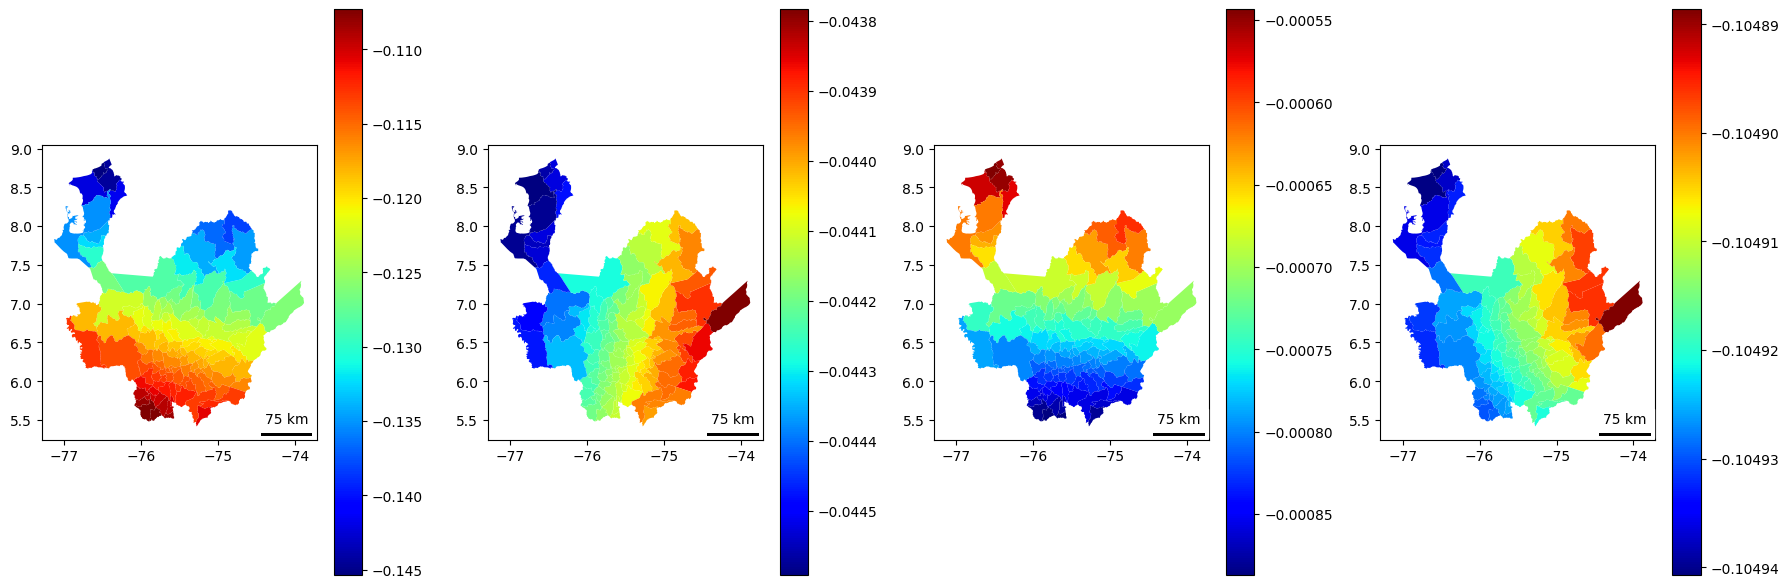

In [144]:
local_params = model.params

param_names = ["altitud", "humedad_relativa", "urbanizacion", "densidad"]
fig, axes = plt.subplots(1, 4, figsize=(18, 6))

data_clean = gdf.to_crs(epsg=4326)

for i, param_name in enumerate(param_names):
    ax = axes[i]
    data_clean[f'coef_{param_name}'] = local_params[:, i+1]
    data_clean.plot(column=f'coef_{param_name}', ax=ax, cmap=plt.cm.jet, legend=True)
    scalebar = ScaleBar(111319.49079327357, "m", location='lower right', scale_loc='top', length_fraction=0.25, font_properties={"size": 10})
    ax.add_artist(scalebar)

plt.tight_layout()
plt.show()

/home/C0d3l7/MyCodes/Python/Geospatial/.geo/lib/python3.10/site-packages/matplotlib_scalebar/scalebar.py:457: UserWarning: Drawing scalebar on axes with unequal aspect ratio; either call ax.set_aspect(1) or suppress the warning with rotation='horizontal-only'.
  warnings.warn(


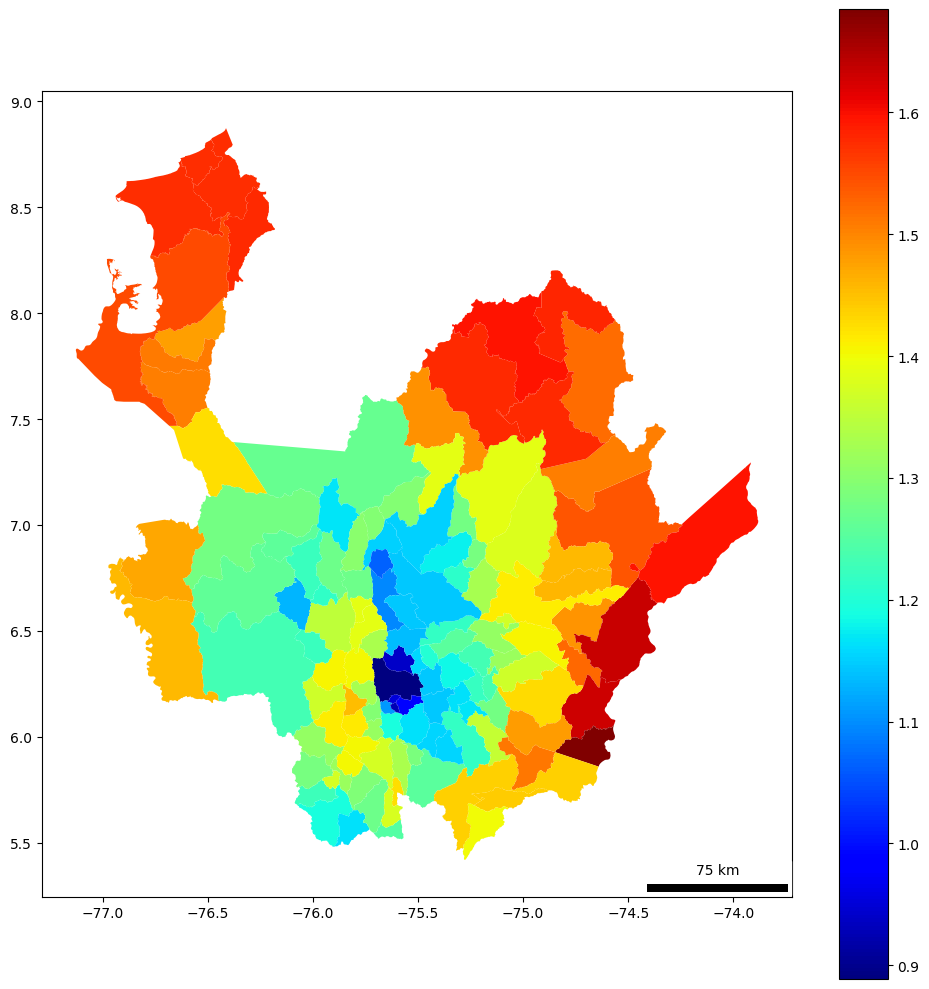

In [145]:
fig, ax = plt.subplots(figsize=(10, 10))
data_clean['fitted'] = model.predy
data_clean.plot(column='fitted', ax=ax, cmap=plt.cm.jet, legend=True)
scalebar = ScaleBar(111319.49079327357, "m", location='lower right', scale_loc='top', length_fraction=0.25, font_properties={"size": 10})
ax.add_artist(scalebar)
plt.tight_layout()
plt.show()